# Intento 1: IMPORTAR DIRECTAMENTE DE SHP A GEOSJON



In [22]:
!pip install h3 geojson folium branca geopandas area pyshp

     |████████████████████████████████| 225kB 2.7MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=1d024a5bffcb09f296a78b08dbc6709b2a951bb9051777a9b3415c3d12fb014b
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [121]:
#You need to have cc, make, and cmake in your $PATH when installing this package:
from h3 import h3


In [122]:
import geopandas as gpd
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

import statistics

from geojson.feature import *
from area import area

import copy

In [123]:
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
import folium

import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
from IPython.display import Image, display
from IPython.utils.text import columnize
import warnings
warnings.filterwarnings('ignore')

In [125]:
%matplotlib inline


Nos damos cuenta que nos da un error de utf-8, por lo que procuramos que el encoding sea el adecuado al dataset, "latin-1", cuando leemos el archivo SHP

In [126]:
import shapefile
import geopandas as gpd
reader = shapefile.Reader("Comunidades_Autonomas_ETRS89_30N.shp", encoding= 'latin-1')

fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []

In [127]:
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 

In [128]:
# write the GeoJSON file
from json import dumps


geojson_esp = open("cccaa.json", "w")
geojson_esp.write(dumps({"type": "FeatureCollection","features": buffer}, indent=2) + "\n")


geojson_esp.close()


In [129]:
with open("cccaa.json") as f:
    subzones_geodata_json = json.load(f)
    

df_subzones_json = pd.DataFrame(json_normalize(subzones_geodata_json['features']))
# df_subzones.crs=25831


df_subzones_json.head(10)

,type,geometry.type,geometry.coordinates,properties.Codigo,properties.Texto,properties.Texto_Alt
0,Feature,MultiPolygon,"[[[[280486.7521693756, 3993822.4436541195], [2...",01,Andalucía,Andalucía
1,Feature,Polygon,"[[[683851.1023732608, 4754656.795357257], [684...",02,Aragón,Aragón
2,Feature,Polygon,"[[[271018.94236425834, 4838166.721856209], [27...",03,Principado de Asturias,Asturias
3,Feature,MultiPolygon,"[[[[885504.7053501, 4299411.461205398], [88593...",04,Islas Baleares,Illes Balears
4,Feature,MultiPolygon,"[[[[-978944.2763622939, 3171831.877355155], [-...",05,Canarias,Canarias
5,Feature,MultiPolygon,"[[[[478589.6993137827, 4790369.391146412], [47...",06,Cantabria,Cantabria
6,Feature,MultiPolygon,"[[[[505342.00518752733, 4715778.123607973], [5...",07,Castilla y León,Castilla y León
7,Feature,MultiPolygon,"[[[[468371.2839158552, 4498889.720412486], [46...",08,Castilla - La Mancha,Castilla - La Mancha
8,Feature,MultiPolygon,"[[[[825344.7959900943, 4515383.249505202], [82...",09,Cataluña,Catalunya
9,Feature,MultiPolygon,"[[[[720290.7764271639, 4227118.177136581], [72...",10,Comunidad Valenciana,Comunitat Valenciana


In [130]:
selected_subzone = "09"
df_subzone_sel = df_subzones_json[df_subzones_json["properties.Codigo"] == "09"]
df_subzone_sel["geometry"] = df_subzone_sel.apply(lambda row:{  "type" : row["geometry.type"],
                                                                "coordinates": row["geometry.coordinates"]
                                                              } , axis = 1)

df_subzone_sel

,type,geometry.type,geometry.coordinates,properties.Codigo,properties.Texto,properties.Texto_Alt,geometry
8,Feature,MultiPolygon,"[[[[825344.7959900943, 4515383.249505202], [82...",09,Cataluña,Catalunya,"{'type': 'MultiPolygon', 'coordinates': [[[[82..."


Hasta aquí todo bien, aquí empiezan los problemas: por un lado tenemos el tema de las coordenadas, y por el otro el de escoger el último polígono en el Multipolígono que es Cataluña.
Observamos a continuación que si representamos este el row de Cataluña (que deberíamos ver entera, con todos sus mini-polígonos) no nos deja ver nada por culpa de las coordenadas. 

Reminder: cambiamos de CRS 25830 a 4326

In [131]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(feat_collection_sel['features'])

In [132]:
gdf

,type,id,geometry,properties
0,Feature,09,"MULTIPOLYGON (((825344.796 4515383.250, 825394...",{}


In [133]:
gdf.crs = 25831

#Re-projecting (Changing the CRS)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=4326)

In [134]:
for i in gdf['geometry']:
  print(i)

MULTIPOLYGON (((6.852078841097248 40.72510635068878, 6.852669599276775 40.72508661875852, 6.853204023211247 40.72450869811473, 6.852078841097248 40.72510635068878)), ((6.864120549976688 40.72535889015366, 6.863286986154459 40.72487463220848, 6.860083356696784 40.72902607216393, 6.857371404830049 40.73007571760834, 6.861152861223268 40.72951085403119, 6.864120549976688 40.72535889015366)), ((6.738056742088325 40.78623644412926, 6.737409293025033 40.78631149375978, 6.737019900292331 40.78697252480048, 6.738056742088325 40.78623644412926)), ((8.792737760432008 41.67061197209888, 8.792350572170776 41.66991144989159, 8.792312064089526 41.67041747380522, 8.792737760432008 41.67061197209888)), ((8.80361794586844 41.67290559895557, 8.803240969645101 41.67285269603154, 8.803654332118022 41.67330884863392, 8.80361794586844 41.67290559895557)), ((8.804464452605663 41.67310574490016, 8.804074546939939 41.67290948202509, 8.804499837251997 41.67336502698226, 8.804464452605663 41.67310574490016)), ((

In [135]:
with open('1.txt', 'r') as f:
  mp = f.readline()

In [136]:
from shapely.geometry import Polygon

In [137]:
l = []
for e in mp[1:-1].split(', '):
  l.append((float(e.split(' ')[0])-6, float(e.split(' ')[1])))

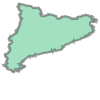

In [138]:
Polygon(l)

In [139]:
#take the first and only row of the dataframe
row_sel = df_subzone_sel.iloc[0]

feature_sel = Feature(geometry = row_sel["geometry"], id=row_sel["properties.Codigo"])
feat_collection_sel = FeatureCollection([feature_sel])
geojson_subzone = json.dumps(feat_collection_sel)


map_subzone = Map(location= [41.724075, 1.5450598], zoom_start=9, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
GeoJson(
        Polygon(l),
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 5,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(map_subzone)


# map_subzone.save('source/6_subzone.html')
map_subzone

In [140]:
#Aqui intento de cambiar el sistema de coordenadas directamente del SHP con Fiona pero no lo consigo
# import fiona
# c = fiona.open("Comunidades_Autonomas_ETRS89_30N.shp", encoding= 'latin-1')
# c.crs

In [141]:
#Aquí lo pruebo con pycrs pero tampoco me aclaro
# import pycrs
# crs = pycrs.load.from_file("Comunidades_Autonomas_ETRS89_30N.shp")
# crs = pycrs.parse.from_esri_code(25830)
# crs.to_epsg_code(4326)


# GOAL: llenarlo de hexagonos

A continuació está el código

In [81]:
p

{"coordinates": [[[3.132932, 41.846082], [3.133723, 41.843663], [3.132407, 41.841862], [3.121522, 41.841076], [3.128578, 41.842859], [3.128427, 41.844289], [3.125661, 41.844572], [3.127972, 41.8457], [3.123727, 41.84788], [3.121956, 41.847237], [3.114721, 41.849001], [3.10446, 41.845679], [3.098461, 41.841858], [3.097246, 41.842373], [3.097558, 41.84097], [3.093848, 41.837531], [3.09343, 41.831874], [3.092119, 41.832771], [3.088464, 41.831805], [3.084751, 41.827052], [3.085391, 41.825937], [3.083671, 41.826452], [3.081309, 41.824516], [3.080929, 41.825335], [3.080196, 41.82413], [3.075427, 41.822768], [3.070947, 41.818273], [3.064692, 41.80288], [3.066447, 41.800792], [3.065191, 41.801878], [3.062802, 41.801722], [3.062674, 41.804471], [3.059197, 41.803982], [3.055296, 41.805044], [3.058525, 41.803509], [3.060854, 41.80364], [3.063127, 41.80054], [3.065291, 41.801171], [3.064086, 41.799155], [3.060996, 41.797981], [3.061531, 41.795135], [3.057843, 41.791363], [3.059278, 41.790413], [3.

In [142]:
from geojson import Polygon
p = Polygon([l])
set_hexagons = h3.polyfill(geo_json = p,res=6)
list_hexagons = list(set_hexagons)
# print("the subzone was filled with ", len(list_hexagons), "hexagons at resolution 9")

In [143]:
len(list_hexagons)

1175

In [144]:
# import pickle
# pickle.dump(list_hexagons, open("hexagons.pkl", "wb"))

In [145]:
# list_hexagons = pickle.load(open("hexagons.pkl", "rb"))

In [146]:
def reverse_lat_lon(hex_coords):
    geom_hex = []
    for lat_lon in hex_coords:
        geom_hex.append([lat_lon[1],lat_lon[0]])
        
    return geom_hex

In [147]:
one_hex_of_fill =  list_hexagons[0]
one_hex_of_fill_coords_latlon = h3.h3_to_geo_boundary(h3_address=one_hex_of_fill,geo_json=False)
# one_hex_of_fill_coords_lonlat = reverse_lat_lon(hex_coords = one_hex_of_fill_coords_latlon)

print(one_hex_of_fill)
print(one_hex_of_fill_coords_latlon)
print(one_hex_of_fill_coords_lonlat)

867ae422fffffff
[[2.999931521220129, 42.26306188377012], [3.03040338409635, 42.273991043892984], [3.0567226427693677, 42.25194869324679], [3.052580262564421, 42.21897081879684], [3.0221089242106505, 42.208030518467424], [2.9957794374982623, 42.23007922883384]]
[[40.96115427684546, 0.4357346580858794], [40.96146033618864, 0.5256008875567517], [40.88304185896102, 0.5747012912682222], [40.80424499495092, 0.5339669377799575], [40.80387915586726, 0.4440553117495984], [40.88236999158293, 0.394923367616347]]


In [148]:
def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    
    '''Produce the GeoJSON for a dataframe that has a geometry column in geojson format already, along with the columns hex_id and value '''
    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result

In [150]:
df_fill_hex = pd.DataFrame({"hex_id": list_hexagons})
df_fill_hex["value"] = 0
df_fill_hex['geometry'] = df_fill_hex.hex_id.apply(lambda x: 
                                                       {    "type" : "Polygon",
                                                             "coordinates": 
                                                   [h3.h3_to_geo_boundary(h3_address=x,geo_json=False)]
                                                        }
                                                    )


geojson_hx = hexagons_dataframe_to_geojson(df_fill_hex)

GeoJson(
        geojson_hx,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'green',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Hexagons" 
    ).add_to(map_subzone)

folium.map.LayerControl('bottomright', collapsed=False).add_to(map_subzone)


map_subzone

# Intento 1: IMPORTAR DIRECTAMENTE DE SHP A GEOSJON



Nos damos cuenta que nos da un error de utf-8, por lo que procuramos que el encoding sea el adecuado al dataset, "latin-1", cuando leemos el archivo SHP

In [0]:
import shapefile
import geopandas as gpd
reader = shapefile.Reader("Comunidades_Autonomas_ETRS89_30N.shp", encoding= 'latin-1')

fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []

In [0]:
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 

In [0]:
# write the GeoJSON file
from json import dumps


geojson_esp = open("cccaa.json", "w")
geojson_esp.write(dumps({"type": "FeatureCollection","features": buffer}, indent=2) + "\n")


geojson_esp.close()


In [0]:
with open("cccaa.json") as f:
    subzones_geodata_json = json.load(f)
    

df_subzones_json = pd.DataFrame(json_normalize(subzones_geodata_json['features']))
# df_subzones.crs=25831


df_subzones_json.head(10)

,type,geometry.type,geometry.coordinates,properties.Codigo,properties.Texto,properties.Texto_Alt
0,Feature,MultiPolygon,"[[[[280486.7521693756, 3993822.4436541195], [280480.7536359...",01,Andalucía,Andalucía
1,Feature,Polygon,"[[[683851.1023732608, 4754656.795357257], [684117.091529311...",02,Aragón,Aragón
2,Feature,Polygon,"[[[271018.94236425834, 4838166.721856209], [270811.93276584...",03,Principado de Asturias,Asturias
3,Feature,MultiPolygon,"[[[[885504.7053501, 4299411.461205398], [885930.2936498288,...",04,Islas Baleares,Illes Balears
4,Feature,MultiPolygon,"[[[[-978944.2763622939, 3171831.877355155], [-978802.359043...",05,Canarias,Canarias
5,Feature,MultiPolygon,"[[[[478589.6993137827, 4790369.391146412], [479773.76612829...",06,Cantabria,Cantabria
6,Feature,MultiPolygon,"[[[[505342.00518752733, 4715778.123607973], [504955.0010899...",07,Castilla y León,Castilla y León
7,Feature,MultiPolygon,"[[[[468371.2839158552, 4498889.720412486], [468487.68447033...",08,Castilla - La Mancha,Castilla - La Mancha
8,Feature,MultiPolygon,"[[[[825344.7959900943, 4515383.249505202], [825394.79867830...",09,Cataluña,Catalunya
9,Feature,MultiPolygon,"[[[[720290.7764271639, 4227118.177136581], [720292.15632347...",10,Comunidad Valenciana,Comunitat Valenciana


In [0]:
selected_subzone = "09"
df_subzone_sel = df_subzones[df_subzones["properties.Codigo"] == "09"]
df_subzone_sel["geometry"] = df_subzone_sel.apply(lambda row:{  "type" : row["geometry.type"],
                                                                "coordinates": row["geometry.coordinates"]
                                                              } , axis = 1)

df_subzone_sel

,type,geometry.type,geometry.coordinates,properties.Codigo,properties.Texto,properties.Texto_Alt,geometry
8,Feature,MultiPolygon,"[[[[825344.7959900943, 4515383.249505202], [825394.79867830...",09,Cataluña,Catalunya,"{'type': 'MultiPolygon', 'coordinates': [[[[825344.79599009..."


Hasta aquí todo bien, aquí empiezan los problemas: por un lado tenemos el tema de las coordenadas, y por el otro el de escoger el último polígono en el Multipolígono que es Cataluña.
Observamos a continuación que si representamos este el row de Cataluña (que deberíamos ver entera, con todos sus mini-polígonos) no nos deja ver nada por culpa de las coordenadas. 

Reminder: cambiamos de CRS 25830 a 4326

In [0]:
#take the first and only row of the dataframe
row_sel = df_subzone_sel.iloc[0]

feature_sel = Feature(geometry = row_sel["geometry"], id=row_sel["properties.Codigo"])
feat_collection_sel = FeatureCollection([feature_sel])
geojson_subzone = json.dumps(feat_collection_sel)


map_subzone = Map(location= [41.724075, 1.5450598], zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
GeoJson(
        geojson_subzone,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 5,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(map_subzone)


# map_subzone.save('source/6_subzone.html')
map_subzone

In [0]:
#Aqui intento de cambiar el sistema de coordenadas directamente del SHP con Fiona pero no lo consigo
# import fiona
# c = fiona.open("Comunidades_Autonomas_ETRS89_30N.shp", encoding= 'latin-1')
# c.crs

In [0]:
#Aquí lo pruebo con pycrs pero tampoco me aclaro
# import pycrs
# crs = pycrs.load.from_file("Comunidades_Autonomas_ETRS89_30N.shp")
# crs = pycrs.parse.from_esri_code(25830)
# crs.to_epsg_code(4326)


# GOAL: llenarlo de hexagonos

A continuació está el código

In [0]:

set_hexagons = h3.polyfill(geo_json = row_sel["geometry"],res=9, geo_json_conformant = True)
list_hexagons = list(set_hexagons)
# print("the subzone was filled with ", len(list_hexagons), "hexagons at resolution 9")

In [0]:
def reverse_lat_lon(hex_coords):
    geom_hex = []
    for lat_lon in hex_coords:
        geom_hex.append([lat_lon[1],lat_lon[0]])
        
    return geom_hex

In [0]:
one_hex_of_fill =  list_hexagons[0]
one_hex_of_fill_coords_latlon = h3.h3_to_geo_boundary(h3_address=one_hex_of_fill,geo_json=False)
one_hex_of_fill_coords_lonlat = reverse_lat_lon(hex_coords = one_hex_of_fill_coords_latlon)

print(one_hex_of_fill)
print(one_hex_of_fill_coords_latlon)
print(one_hex_of_fill_coords_lonlat)

In [0]:
df_fill_hex = pd.DataFrame({"hex_id": list_hexagons})
df_fill_hex["value"] = 0
df_fill_hex['geometry'] = df_fill_hex.hex_id.apply(lambda x: 
                                                       {    "type" : "Polygon",
                                                             "coordinates": 
                                                   [reverse_lat_lon(h3.h3_to_geo_boundary(h3_address=x,geo_json=False))]
                                                        }
                                                    )


geojson_hx = hexagons_dataframe_to_geojson(df_fill_hex)

GeoJson(
        geojson_hx,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'red',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Hexagons" 
    ).add_to(map_subzone)

folium.map.LayerControl('bottomright', collapsed=False).add_to(map_subzone)


map_subzone.save('source/7_filled_subzone.html')
map_subzone

In [0]:
# Intento 1: IMPORTAR DIRECTAMENTE DE SHP A GEOSJON



Nos damos cuenta que nos da un error de utf-8, por lo que procuramos que el encoding sea el adecuado al dataset, "latin-1", cuando leemos el archivo SHP

import shapefile
import geopandas as gpd
reader = shapefile.Reader("Comunidades_Autonomas_ETRS89_30N.shp", encoding= 'latin-1')

fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []

for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 

# write the GeoJSON file
from json import dumps


geojson_esp = open("cccaa.json", "w")
geojson_esp.write(dumps({"type": "FeatureCollection","features": buffer}, indent=2) + "\n")


geojson_esp.close()


with open("cccaa.json") as f:
    subzones_geodata_json = json.load(f)
    

df_subzones_json = pd.DataFrame(json_normalize(subzones_geodata_json['features']))
# df_subzones.crs=25831


df_subzones_json.head(10)

selected_subzone = "09"
df_subzone_sel = df_subzones[df_subzones["properties.Codigo"] == "09"]
df_subzone_sel["geometry"] = df_subzone_sel.apply(lambda row:{  "type" : row["geometry.type"],
                                                                "coordinates": row["geometry.coordinates"]
                                                              } , axis = 1)

df_subzone_sel

Hasta aquí todo bien, aquí empiezan los problemas: por un lado tenemos el tema de las coordenadas, y por el otro el de escoger el último polígono en el Multipolígono que es Cataluña.
Observamos a continuación que si representamos este el row de Cataluña (que deberíamos ver entera, con todos sus mini-polígonos) no nos deja ver nada por culpa de las coordenadas. 

Reminder: cambiamos de CRS 25830 a 4326

#take the first and only row of the dataframe
row_sel = df_subzone_sel.iloc[0]

feature_sel = Feature(geometry = row_sel["geometry"], id=row_sel["properties.Codigo"])
feat_collection_sel = FeatureCollection([feature_sel])
geojson_subzone = json.dumps(feat_collection_sel)


map_subzone = Map(location= [41.724075, 1.5450598], zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
GeoJson(
        geojson_subzone,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 5,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(map_subzone)


# map_subzone.save('source/6_subzone.html')
map_subzone

#Aqui intento de cambiar el sistema de coordenadas directamente del SHP con Fiona pero no lo consigo
# import fiona
# c = fiona.open("Comunidades_Autonomas_ETRS89_30N.shp", encoding= 'latin-1')
# c.crs

#Aquí lo pruebo con pycrs pero tampoco me aclaro
# import pycrs
# crs = pycrs.load.from_file("Comunidades_Autonomas_ETRS89_30N.shp")
# crs = pycrs.parse.from_esri_code(25830)
# crs.to_epsg_code(4326)


# Intento 2: pasamos el geojson a gpd

gpd_esp=gpd.read_file("cccaa.json")
gpd_esp.head(10)


Ahora lo pasamos al sistema de coordenadas adecuado: partimos de EPSG 25831

gpd_esp.crs=25830

gpd_esp['geometry']= gpd_esp['geometry'].to_crs(epsg=4326)
gpd_esp.head(10)

selected_subzone = "09"
df_cat_multi = gpd_esp[gpd_esp["Codigo"] == "09"]
df_cat_multi["geometry"] = df_subzone_sel.apply(lambda row:{  "type" : row["geometry.type"],
                                                                "coordinates": row["geometry.coordinates"]
                                                              } , axis = 1)


map_subzone = Map(location= [41.724075, 1.5450598], zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
GeoJson(
        gpd_esp['geometry'].iloc[8],
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'blue',
            'weight': 5,
            'fillOpacity': 0
        }, 
        name = "Subzone" 
    ).add_to(map_subzone)


# map_subzone.save('source/6_subzone.html')
map_subzone

A continuación selecciono el polígono que tiene un área mayor, o sea Cataluña (pero a partir de aquí ya no avanzo más)

print(max(gpd_esp["geometry"], key=lambda a: a.area))

En última instancia queda lo que probamos el otro día que ya vimos que no funcionó: pasar el shp a geopandas directamente pero luego el formato no nos sirve para el script de H·

pasamos el dataframe a un GEOPANDAS dataframe para hacer el cambio de CRS

escogemos la row que queremos y desmontamos el multipolygon

# from shapely.geometry import shape, mapping
# row_sel = df_subzone_sel.iloc[0]

# multi=row_sel["geometry"]


# Multipoly = shape(multi)
# for poly in Multipoly:
#      print (poly.wkt)

# # Polygons=list(multi)

# for poly in Multipoly:
#     poly_final=poly
#     print (mapping(poly))



# GOAL: llenarlo de hexagonos

A continuació está el código


set_hexagons = h3.polyfill(geo_json = row_sel["geometry"],res=9, geo_json_conformant = True)
list_hexagons = list(set_hexagons)
# print("the subzone was filled with ", len(list_hexagons), "hexagons at resolution 9")



def reverse_lat_lon(hex_coords):
    geom_hex = []
    for lat_lon in hex_coords:
        geom_hex.append([lat_lon[1],lat_lon[0]])
        
    return geom_hex

one_hex_of_fill =  list_hexagons[0]
one_hex_of_fill_coords_latlon = h3.h3_to_geo_boundary(h3_address=one_hex_of_fill,geo_json=False)
one_hex_of_fill_coords_lonlat = reverse_lat_lon(hex_coords = one_hex_of_fill_coords_latlon)

print(one_hex_of_fill)
print(one_hex_of_fill_coords_latlon)
print(one_hex_of_fill_coords_lonlat)

df_fill_hex = pd.DataFrame({"hex_id": list_hexagons})
df_fill_hex["value"] = 0
df_fill_hex['geometry'] = df_fill_hex.hex_id.apply(lambda x: 
                                                       {    "type" : "Polygon",
                                                             "coordinates": 
                                                   [reverse_lat_lon(h3.h3_to_geo_boundary(h3_address=x,geo_json=False))]
                                                        }
                                                    )


geojson_hx = hexagons_dataframe_to_geojson(df_fill_hex)

GeoJson(
        geojson_hx,
        style_function=lambda feature: {
            'fillColor': None,
            'color': 'red',
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Hexagons" 
    ).add_to(map_subzone)

folium.map.LayerControl('bottomright', collapsed=False).add_to(map_subzone)


map_subzone.save('source/7_filled_subzone.html')
map_subzone





